In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.7 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np 
import random

import cv2
import numpy as np
from keras.utils import to_categorical
import os
import pandas as pd

# Setting seeds for reproducibility.
SEED = 11
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Mounted Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/project2VDT/sourceCode/data.zip -d /

**Construct data**

In [ ]:
INPUT_PATH = '/content/data'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

**dataset for classification**

In [ ]:
id_pos = np.where(y == 1)[0]
id_neg = np.where(y == 0)[0]

np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

id_train_neg = id_neg[:int(len(id_neg) * 0.7)]
id_train_pos = id_pos[:int(len(id_pos) * 0.7)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

id_val_neg = id_neg[int(len(id_neg) * 0.7):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.7):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [ ]:
#train
x_train = X[id_train]
y_train = y[id_train]
#val
x_val = X[id_val]
y_val = y[id_val]
#test
x_test = X[id_test]
y_test = y[id_test]

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_train = to_categorical(y_train,dtype = 'int32')
y_val = to_categorical(y_val,dtype = 'int32')
y_test = to_categorical(y_test,dtype = 'int32')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8272, 96, 96, 3) - y_train shape: (8272, 2)
x_val shape: (2363, 96, 96, 3) - y_val shape: (2363, 2)
x_test shape: (1183, 96, 96, 3) - y_test shape: (1183, 2)


**HyperParameter Setup**

In [ ]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = input_shape
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 96  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

mlp_head_units = [2048, 1024]

SEED = 11 

**Util**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.activations import gelu
import numpy as np

#Patch image to subimage (adapt with input of visionTransformer)
class Patches(layers.Layer):
    def __init__(self,patch_size = PATCH_SIZE):
        super(Patches,self).__init__()
        self.patch_size = patch_size
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))
    
    def call(self, images):
        # print(images.shape)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # print(patches.shape)

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

def get_angle(pos, i, d_model):
    indices = i // 2
    angle_rates = 1 / np.power(10000,(2*indices) / np.float32(d_model))
    
    return pos * angle_rates
    
def pos_encoding(pos,d_model):
    angle_rads = get_angle(np.arange(pos)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class PatchEncoder(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, projection_dim=ENC_PROJECTION_DIM, mask_proportion = MASK_PROPORTION, downstream = False):
        super(PatchEncoder,self).__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )
        self.downstream = downstream

    def build(self, input_shape):
        (_,self.num_patches, self.patch_area) = input_shape
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = pos_encoding(pos = self.num_patches, d_model = self.projection_dim)
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        position_embedding = self.position_embedding
        # print("phase0: ",self.position_embedding.shape)
        position_embedding = tf.tile(
            position_embedding, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)
        # print("phase1: ",self.position_embedding.shape)
        # print("phase2: ",self.projection(patches).shape)
        patch_embeddings = (self.projection(patches) + position_embedding)
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                position_embedding, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            masked_positions = tf.gather(
                position_embedding, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)        

            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )
    
    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, mlp_dim, dropout):
        super(TransformerBlock,self).__init__()
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadAttention(
            num_heads = self.num_heads,
            key_dim = input_shape[-1] // self.num_heads #d_model is input_shape[-1]
        )
        
        self.mlpBlock = Sequential([
            Dense(self.mlp_dim[0],activation=tf.nn.gelu),
            Dropout(self.dropout),
            Dense(self.mlp_dim[1],activation=tf.nn.gelu),
            Dropout(self.dropout),
        ])

        self.layerNorm1 = LayerNormalization(epsilon = LAYER_NORM_EPS)
        self.layerNorm2 = LayerNormalization(epsilon = LAYER_NORM_EPS)
        self.layerDropout = Dropout(self.dropout)
    
    def call(self, inputs, training):
        # query = [
        #     inputs[:,0:85,0:21], #eye left
        #     inputs[:,0:85,43:], #eye right
        #     inputs[:,85:170,21:43], #nose
        #     inputs[:,170:,21:43], #mouth
        # ]
        # queries = tf.concat(queries, axis=0)
        x = self.att(inputs,inputs)
        x = self.layerDropout(x, training = training)
        x = x + inputs
        y = self.layerNorm2(x)
        y = self.mlpBlock(y)
        x = x + y
        x = self.layerNorm1(x)
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units = units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def Encoder(num_heads = ENC_NUM_HEADS, num_layers = ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x = TransformerBlock(num_heads,ENC_TRANSFORMER_UNITS,0.1)(x)
    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

def Decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(num_heads,DEC_TRANSFORMER_UNITS,0.1)(x)
    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)
    return keras.Model(inputs=inputs, outputs=outputs,name="mae_decoder")

**Augmentation for autoencoder task**

In [ ]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.RandomCrop(92, 92, seed=SEED, input_shape=input_shape),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal", seed=SEED),
            layers.RandomRotation(0.2, seed=SEED),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

**Model**

In [ ]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
    ):
        super(MaskedAutoencoder,self).__init__()
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)
        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

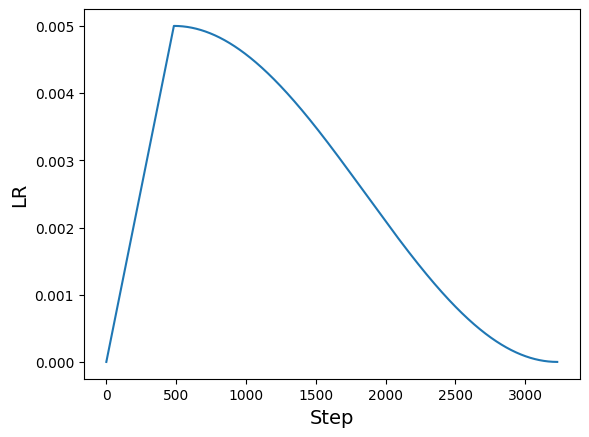

NameError: ignored

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

**Compile and training**

In [ ]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = Encoder()
decoder = Decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [ ]:
mae_model.save_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/MAE_75/MAE_75')

**Use encoder for classification Task**

In [ ]:
mae_model.load_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/MAE_75/MAE_75')

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="classification",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_1 (Patches)         (None, 256, 108)          0         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 256, 128)         14060     
 er)                                                             
                                                                 
 mae_encoder (Functional)    (None, None, 128)         795136    
                                                                 
 batch_normalization (BatchN  (None, 256, 128)         512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                    

In [ ]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_val, y_val, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [ ]:
linear_probe_epochs = 100
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=2)]
)

# earlystopping_cb = keras.callbacks.EarlyStopping(monitor="f1_score", patience = 20)
history = downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy, f1_score_res = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")
print("f1_score: ", f1_score_res)

In [ ]:
downstream_model.save_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/CLASSIFICATION_MAE_75/CLASSIFICATION_MAE_75')

**Finetune q,k,v and training**

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

def down_stream_queryFineTune():
    inputs = layers.Input((96, 96, 3))
    patches = patch_layer(inputs)
    x = patch_encoder(patches)
    mat_trai = x[:,0:85,0:36]
    mat_phai = x[:,0:85,72:108]
    mui = x[:,85:170,36:72]  #Facial Landmark
    mieng = x[:,170:255,36:72]
    
    encoded_patches = encoder(x)

    dim_k = 32
    dim_v = 64
    dense_q = tf.keras.layers.Dense(units=dim_k)
    dense_k = tf.keras.layers.Dense(units=dim_k)
    dense_v = tf.keras.layers.Dense(units=dim_v)

    queries = tf.concat([dense_q(mat_trai), dense_q(mat_phai), dense_q(mui), dense_q(mieng)], axis = 1)
    keys = dense_k(encoded_patches)
    values = dense_v(encoded_patches)

    cross_attention_output = layers.MultiHeadAttention(
        num_heads=4, key_dim=64, dropout=0.1
    )(query=queries, value=values, key=keys)


    representation = layers.LayerNormalization(epsilon=1e-6)(cross_attention_output)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=[64,32], dropout_rate=0.5)

    # x = layers.BatchNormalization(epsilon=1e-6)(representation)
    # features = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(features)
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
mae_classier = down_stream_queryFineTune()

for layer in mae_classier.layers[:-8]:
    layer.trainable = False

mae_classier.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 patches_1 (Patches)            (None, 256, 108)     0           ['input_19[0][0]']               
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 256, 128)    14060       ['patches_1[14][0]']             
                                                                                                  
 tf.__operators__.getitem_44 (S  (None, 85, 36)      0           ['patch_encoder_1[14][0]']       
 licingOpLambda)                                                                           

In [ ]:
linear_probe_epochs = 100
linear_prob_lr = 0.01
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
mae_classier.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=2)]
)

# earlystopping_cb = keras.callbacks.EarlyStopping(monitor="f1_score", patience = 20)
history = mae_classier.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy, f1_score_res = mae_classier.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")
print("f1_score: ", f1_score_res)

Epoch 1/100
33/33 [==============================] - 48s 397ms/step - loss: 1.2848 - accuracy: 0.4160 - f1_score: 0.2945 - val_loss: 1.0489 - val_accuracy: 0.4156 - val_f1_score: 0.2936
Epoch 2/100
33/33 [==============================] - 13s 377ms/step - loss: 1.0984 - accuracy: 0.4159 - f1_score: 0.2942 - val_loss: 0.9413 - val_accuracy: 0.4156 - val_f1_score: 0.2936
Epoch 3/100
33/33 [==============================] - 13s 384ms/step - loss: 0.9422 - accuracy: 0.4176 - f1_score: 0.2973 - val_loss: 0.8119 - val_accuracy: 0.4160 - val_f1_score: 0.2944
Epoch 4/100
33/33 [==============================] - 12s 367ms/step - loss: 0.8307 - accuracy: 0.4191 - f1_score: 0.3052 - val_loss: 0.7266 - val_accuracy: 0.4160 - val_f1_score: 0.2944
Epoch 5/100
33/33 [==============================] - 12s 359ms/step - loss: 0.7683 - accuracy: 0.1225 - f1_score: 0.1155 - val_loss: 0.6934 - val_accuracy: 0.4257 - val_f1_score: 0.3205
Epoch 6/100
33/33 [==============================] - 13s 379ms/step - 

In [ ]:
# mae_classifier.load_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/CLASSIFICATION_MAE_75/CLASSIFICATION_MAE_75')

In [ ]:
# downstream_model.load_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/CLASSIFICATION_MAE_75/CLASSIFICATION_MAE_75')

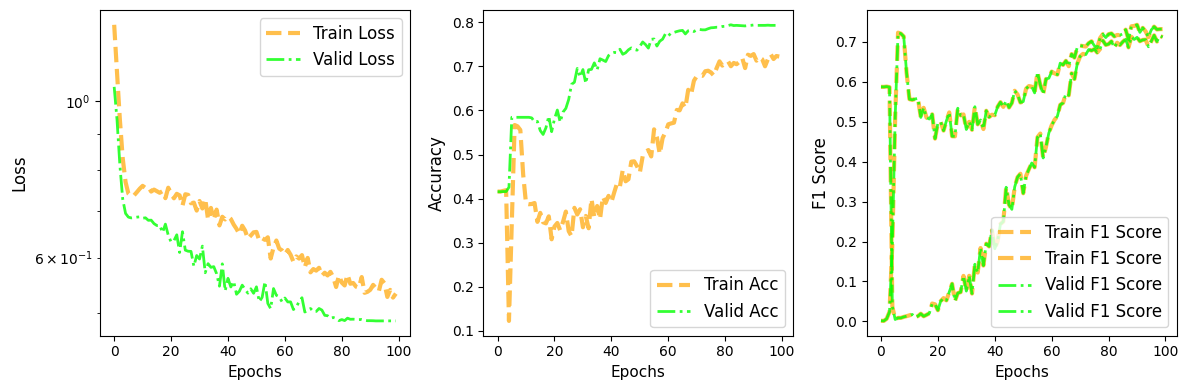

In [ ]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_score']
val_f1_score = history['f1_score']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

**Inference**

5/5 [==============================] - 4s 214ms/step
GROUND TRUTH: 
Label 1:  1183
Label 0:  1183
PREDICTION: 
Label 1:  1183
Label 0:  1183


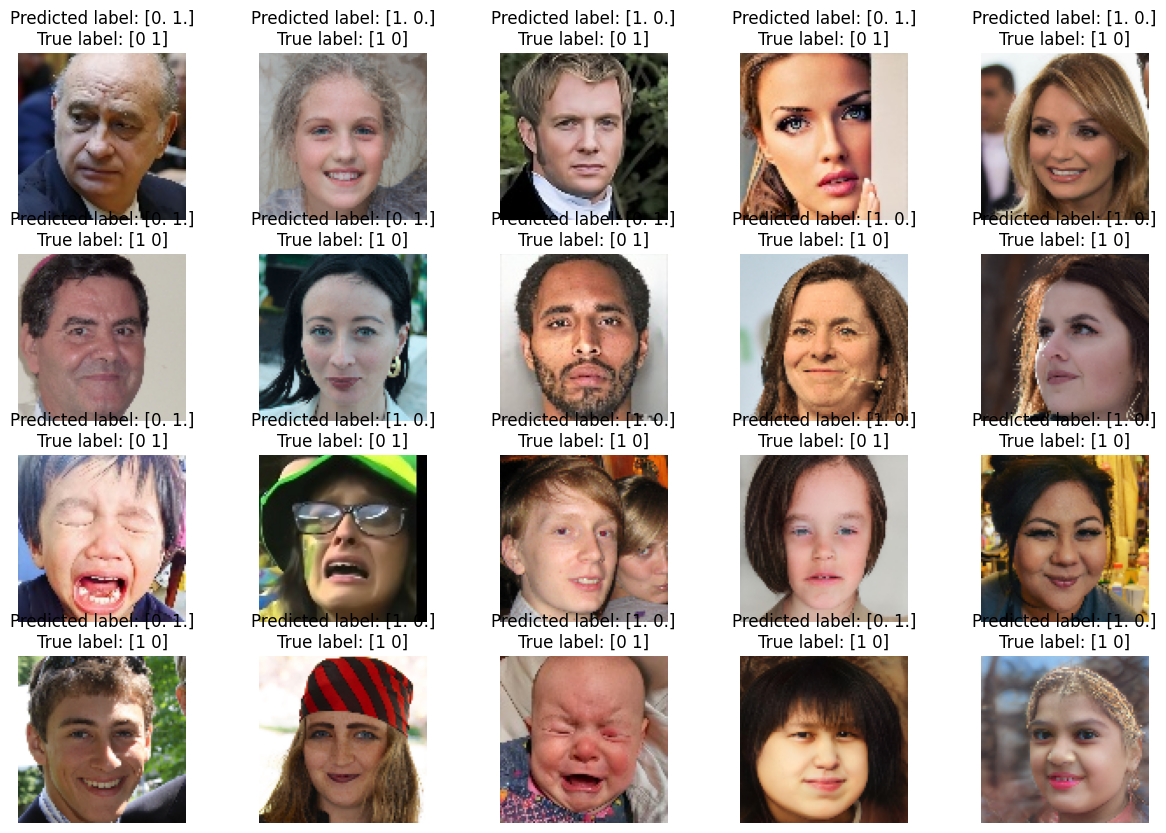

In [ ]:
# use model to predict and plot the result
y_pred = mae_classier.predict(test_ds)
y_pred = np.round(y_pred)

print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y_test == 1))
print(f"Label 0: ", np.count_nonzero(y_test == 0))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_pred == 1))
print(f"Label 0: ", np.count_nonzero(y_pred == 0))

# plot random 20 x_test and their predicted labels and ground truth labels
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    ax = axs[i//5, i%5]
    index = np.random.randint(0, len(x_test))
    ax.imshow(x_test[index])
    ax.set_title(f"Predicted label: {y_pred[index]}\nTrue label: {y_test[index]}")
    ax.axis('off')

In [ ]:
INPUT_PATH = '/content/drive/MyDrive/project2VDT/sourceCode/InferenceData'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

In [ ]:
y = y.reshape((-1, 1))
y = to_categorical(y,dtype = 'int32')
test_ds = prepare_data(X, y, is_train=False)

1/1 [==============================] - 0s 78ms/step
GROUND TRUTH: 
Label 1:  22
Label 0:  22
PREDICTION: 
Label 1:  26
Label 0:  18


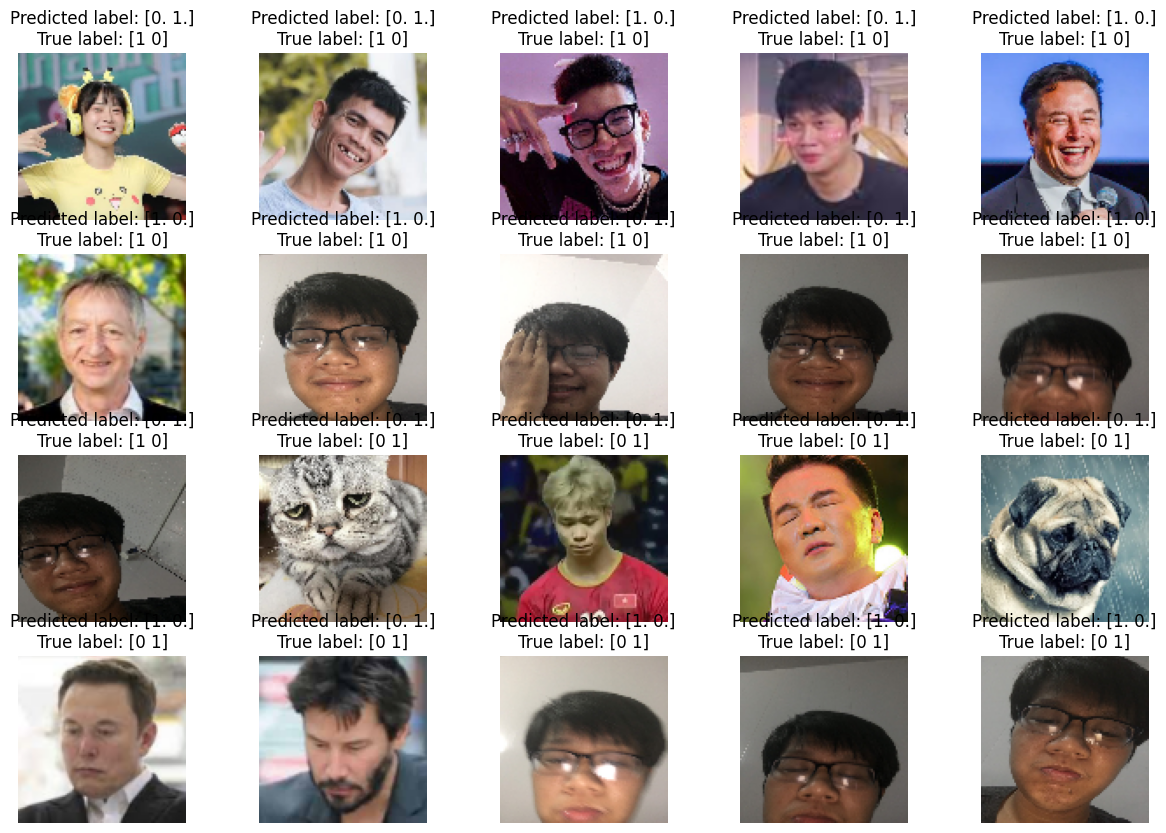

In [ ]:
y_infer = mae_classier.predict(test_ds)
y_infer = np.round(y_infer)
print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y == [0,1]))
print(f"Label 0: ", np.count_nonzero(y == [1,0]))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_infer == [0,1]))
print(f"Label 0: ", np.count_nonzero(y_infer == [1,0]))


# plot random 20 x_test and their predicted labels and ground truth labels
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.set_title(f"Predicted label: {y_infer[i]}\nTrue label: {y[i]}")
    ax.axis('off')